In [1]:
import tensorflow as tf

In [2]:
import numpy as np
import numpy.random as rnd

In [3]:
import matplotlib.pyplot as pl
%matplotlib inline

In [4]:
floatX = np.float32

In [5]:
sess = tf.InteractiveSession()

In [6]:
import os

In [7]:
xx1 = tf.Variable(
    initial_value = tf.random_normal([10]), 
    validate_shape = False, 
    dtype = floatX, 
    name = "xx"
)
xx1.set_shape([None])

In [8]:
xx2 = tf.Variable(
    initial_value = tf.random_normal([10]), 
    validate_shape = False, 
    dtype = floatX, 
    name = "xx"
)
xx2.set_shape([None])

# Model organization 01

In [9]:
class AffineModel_01:
    def __init__(self, name):
        self.name = name
        with tf.variable_scope(name):
            self.a = tf.get_variable(name = "a", dtype = floatX, initializer = 1.0)
            self.b = tf.get_variable(name = "b", dtype = floatX, initializer = 0.0)

    def predict(self, x, name):
        a, b = self.a, self.b
        with tf.variable_scope(name):
            x = tf.identity(x, name= "x")
            linear_part = tf.multiply(a, x, "linear_part")
            y = tf.identity(linear_part + b, "y")
            return y
        
    def plot_calculation(self, y, feed_dict = None):
        scope = os.path.split(y.name)[0]
        graph = y.graph
        x = graph.get_tensor_by_name(scope + "/x:0")
        xxx, yyy = sess.run([x, y], feed_dict)
        
        pl.scatter(xxx, yyy)

        

In [10]:
model = AffineModel_01("affine_model_01")

In [11]:
yy1 = model.predict(x = xx1, name = "prediction")
yy2 = model.predict(x = xx2, name = "prediction")

In [12]:
sess.run(tf.global_variables_initializer())

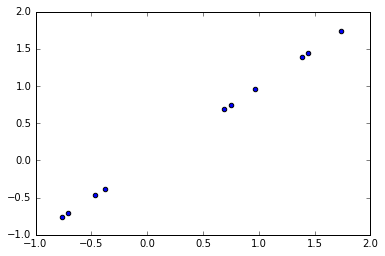

In [13]:
model.plot_calculation(yy1)

# Model organization 02

In [14]:
import types

In [15]:
class AffineModel_02:
    instance_counter = 0
    
    def __init__(self, name = None):
        self.__class__.instance_counter += 1
        self.piname = "{}_instance{}".format(
                self.__class__.__name__,
                self.__class__.instance_counter,
            )               
        if name is None:
            name = self.piname
            
        self.call_counter = 0
            
        with tf.variable_scope(name) as scope:
            self.name = scope.name
            self.a = tf.get_variable(name = "a", dtype = floatX, initializer = 1.0)
            self.b = tf.get_variable(name = "b", dtype = floatX, initializer = 0.0)
            

    def __call__(self, x, name = None):
        self.call_counter += 1
        if name is None:
            name = "{}_call{}".format(
                self.piname,
                self.call_counter
            )
        a, b = self.a, self.b
        with tf.variable_scope(name) as scope:
            x = tf.identity(x, name= "x")
            linear_part = tf.multiply(a, x, "linear_part")
            y = tf.identity(linear_part + b, "y")
            
            y.piplot = lambda feed_dict = None: self.plot_calculation(x, y, feed_dict)
            
            return y
        
    def plot_calculation(box, x, y, feed_dict = None):
        xxx, yyy = sess.run([x, y], feed_dict)
        
        pl.scatter(xxx, yyy)

        

In [16]:
model = AffineModel_02()

In [17]:
yy1 = model(x = xx1, name = "prediction")
yy2 = model(x = xx2, name = "prediction")

In [18]:
sess.run(tf.global_variables_initializer())

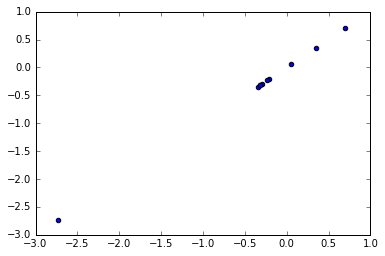

In [19]:
yy1.piplot()

# Model organization 01

In [20]:
import functools
from functools import wraps

In [21]:
def namescope_method(fun):
    @wraps(fun)
    def wrapped(self, *args, **kwargs):
        name = "{}.{}".format(self.name, fun.__name__)
        with tf.name_scope(name):
            return fun(self, *args, **kwargs)
    return wrapped

In [22]:
class AffineModel_03:
    def __init__(self, name):
        self.name = name
        with tf.variable_scope(name):
            self.a = tf.get_variable(name = "a", dtype = floatX, initializer = 1.0)
            self.b = tf.get_variable(name = "b", dtype = floatX, initializer = 0.0)

    @namescope_method
    def predict(self, x):
        a, b = self.a, self.b
        x = tf.identity(x, name= "x")
        linear_part = tf.multiply(a, x, "linear_part")
        y = tf.identity(linear_part + b, "y")

        y.piplot = lambda feed_dict = None: self.plot_calculation(x, y, feed_dict)

        return y
        
    def plot_calculation(box, x, y, feed_dict = None):
        xxx, yyy = sess.run([x, y], feed_dict)
        
        pl.scatter(xxx, yyy)
        

In [23]:
model = AffineModel_03("affine_model_03")

In [24]:
yy1 = model.predict(x = xx1)
yy2 = model.predict(x = xx2)

In [25]:
sess.run(tf.global_variables_initializer())

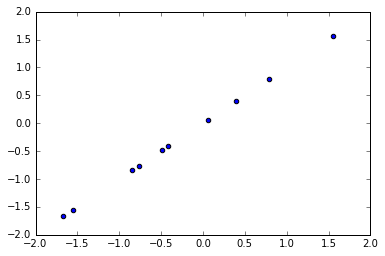

In [26]:
yy1.piplot()

### Tensorboard

In [27]:
tb_dir = r"D:\python_source\data\bordel\tesorboard_test_01"
tb_dir 

'D:\\python_source\\data\\bordel\\tesorboard_test_01'

In [28]:
tb_writer = tf.summary.FileWriter(tb_dir)
tb_writer.add_graph(tf.get_default_graph())

# Bordel

#### Class Descriptors

In [28]:
class SampleDescriptor:
    def __init__(self, name):
        self.name = name
        
    def __get__(self, obj, objtype):
        return "Descriptor {} of obj = {}, objtype = {}".format(
            self.name, obj, objtype)
            

In [29]:
class A:
    x = SampleDescriptor(name = "class_property_x" )
    
    def __init__(self, name):
        self.name = name
        self.y = SampleDescriptor(name = "instance_property_y")
        
    def __str__(self):
        return self.name

In [139]:
class B(A):
    pass

In [30]:
a = A("a")

In [31]:
a.x

"Descriptor class_property_x of obj = a, objtype = <class '__main__.A'>"

In [33]:
A.x

"Descriptor class_property_x of obj = None, objtype = <class '__main__.A'>"

In [34]:
a.y

In [35]:
A.y

AttributeError: type object 'A' has no attribute 'y'

In [141]:
b = B("b")

In [142]:
b.x

"Descriptor class_property_x of obj = b, objtype = <class '__main__.B'>"

#### Muslitple inheritance

In [39]:
class First(object):
    def __init__(self):
        print("first")

class Second(object):
    def __init__(self):
        print("second")

class Third(First, Second):
    def __init__(self):
        super(Third, self).__init__()
        print("that's it")
        
Third()

first
that's it


#### Try automatic counting of class instances

In [87]:
class NoofInstancesDescriptor:
    def __get__(self, obj, cls):
        if "_noof_instances" not in cls.__dict__:
            cls._noof_instances = 0
            
        return cls._noof_instances
    
        

In [137]:
def counted_class(clazz):
#    @wraps(clazz)
    class NewCls(clazz):
    #clazz.noof_instances = NoofInstancesDescriptor()
        _noof_instances = 0

        @wraps(clazz.__init__)
        def __init__(self, *args, **kwargs):
            self.__class__._noof_instances +=1
            clazz.__init__(self, *args, **kwargs)

    functools.update_wrapper(NewCls, clazz)
    return NewCls

In [144]:
class CountedClass:
    noof_instances = NoofInstancesDescriptor()

#### Prepare code to use in main article

In [136]:
import functools
from functools import wraps

In [15]:
def namescope_method(fun):
    @wraps(fun)
    def wrapped(self, *args, **kwargs):
        name = "{}.{}".format(self.name, fun.__name__)
        with tf.name_scope(name):
            return fun(self, *args, **kwargs)
    return wrapped

In [150]:
class C:
    """
    This is docstring of class `C`.
    """
    noof_instances = 0
    def __init__(self, name = None):
        self.__class__.noof_instances += 1
        if name is None:
            name = "inst_{}_of_{}".format(
                self.__class__.noof_instances, self.__class__.__name__
            )
        
        self.name = name
     
    @namescope_method
    def f(self, x):
        y = tf.identity(x + 1, "y")
        return y

In [151]:
C.noof_instances

0

In [152]:
c0 = C()

In [156]:
c0.name

'inst_1_of_C'

In [154]:
C.noof_instances

1

In [155]:
c1 = C("Adriana")
C.noof_instances

2

In [135]:
C.__doc__

In [125]:
C

__main__.counted_class.<locals>.NewCls

In [66]:
C.noof_instances

1

In [70]:
c.name

AttributeError: 'C' object has no attribute 'name'

In [68]:
c = C("Dolly")

In [69]:
C.noof_instances

3

In [18]:
y = c.f(1)
y.name

In [20]:
y2 = c.f(1)
y2.name

'Adriana.f_1/y:0'